In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText, TextStreamer
from PIL import Image
import requests
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import re
import json
from tqdm.auto import tqdm
import pandas as pd

/data2/sandeep/ENVS/hbmeter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-17 23:23:42.505654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 23:23:42.519974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752774822.537819  420408 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752774822.543493  420408 cuda_blas.cc:1407] Una

In [2]:
ki67 = Path('/data2/sandeep/PATHOLOGY-VLM/dataset/2023-03-03')
ki67_images = list(ki67.glob('*'))

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import torch

# === Local model path ===
model_path = "/data2/sandeep/medgemma-4b-it"

# === Load model and processor from local ===
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    local_files_only=True  # Ensures 100% offline
)
processor = AutoProcessor.from_pretrained(model_path, local_files_only=True)

# === Load image from disk ===
image_path = "dataset/2023-03-03/14-40X-40X-1-00DX-2023-03-03-16-07-27.jpg"
image = Image.open(image_path).convert("RGB")

# === Custom prompt ===
user_prompt = """Answer the following from the provided image with staining.
Answer the following questions:
1. Is there any nuclear staining in brown in this image? [yes/no]
2. If there is staining, calculate the approximate proportion of cells that are stained.
3. If there is staining, grade the staining in levels [1,2,3] where 3 indicates intense brown staining and 1,2 are relative to 3.
The image can have multiple levels of staining."""

# === Prepare messages ===
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a medical vision model specialized in analyzing stained tissue images."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": user_prompt},
            {"type": "image", "image": image}
        ]
    }
]

# === Preprocess ===
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

# === Generate ===
input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(
        **inputs,
        max_new_tokens=300,
        do_sample=False
    )
    generation = generation[0][input_len:]

# === Decode output ===
decoded = processor.decode(generation, skip_special_tokens=True)
print("\n🧠 Model Output:\n", decoded)


In [4]:
messages = [
    {
        'role': 'system',
        "content": [{"type": "text", "text": "You are an expert pathologist."}]
    },
    {
        'role': 'user',
        'content': [
            {"type": "text", "text": user_prompt},
        ]
    }
]

In [9]:
model_id = "google/medgemma-4b-it"

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`

In [ ]:
streamer = TextStreamer(
    tokenizer=processor.tokenizer,
    skip_prompt=True,
    skip_special_tokens=True
)

In [8]:
def predict(image, messages, show_image=True):
    messages = messages.copy()
    image = Image.open(image).convert('RGB').resize((1024,1024))
    if image is not None:
        messages[1]['content'].append(
            {"type": "image", "image": image}
        )
    inputs = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to(model.device, dtype=torch.bfloat16)
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    model.config.pad_token_id = model.config.eos_token_id

    input_len = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(
            **inputs,
            max_new_tokens=1024,
            do_sample=False,
            top_k=None,
            top_p=None,
        )
        generation = generation[0][input_len:]

    decoded = processor.decode(generation, skip_special_tokens=True)

    if show_image:
        plt.axis('off')
        plt.imshow(image.resize((500,500)))
        plt.show()

    return decoded

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


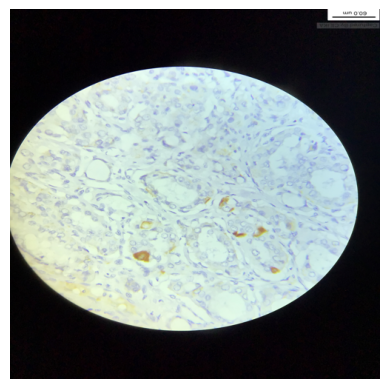

'```json\n{\n    "type_of_stain": "nuclear",\n    "brown_stain": "yes",\n    "stain_proportion": 0.6,\n    "stain_levels": [\n        2,\n        3\n    ],\n    "report": "The image shows a histological section with nuclear staining. The staining appears to be present in approximately 60% of the cells. The staining intensity is moderate to intense, with some cells showing a more intense brown color than others."\n}\n```'

In [9]:
predict(
    '/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-04/33-40X-1-00DX-2023-03-04-15-35-26.jpg',
    messages
)

In [ ]:
def get_json(raw):
    match = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", raw, re.DOTALL)
    if not match:
        raise ValueError("No JSON content found")

    json_like = match.group(1)

    # Replace non-JSON-compliant values (like unquoted yes → "yes")
    json_like = re.sub(r'(?<=:\s)(yes|no)(?=[,\n\}])', r'"\1"', json_like)

    # Parse into a Python dict
    data = json.loads(json_like)
    return data

In [ ]:
def predict_report(image, messages, idx):
    print(idx)
    try:
        res = predict(image, messages, show_image=False)
        res = get_json(res)
    except Exception as e:
        print(e)
        res = predict_report(image, messages, idx)
    return res

In [ ]:
messages

In [ ]:
predict('/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-04/33-40X-1-00DX-2023-03-04-15-35-26.jpg',messages)

In [ ]:
results = []
for idx, image in tqdm(enumerate(ki67_images),total=len(ki67_images)):
    res = predict_report(image, messages, idx)
    res['image'] = image
    results.append(res)

In [ ]:
ki67_df = pd.DataFrame(results)
ki67_df.to_csv('./dataset/2023-03-03.csv',index=False)

In [ ]:
ihc = Path('/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-04')
ihc_images = list(ihc.glob('*'))

In [ ]:
results = []
for image in tqdm(ihc_images):
    res = predict_report(image, messages,idx)
    res['image'] = image
    results.append(res)
ki67_df = pd.DataFrame(results)
ki67_df.to_csv('./dataset/2023-03-04.csv',index=False)

In [ ]:
user_prompt2 = """You are provided with an image showing Ki67 staining, your task is to analyze this image to assess the presence, proportion, and intensity of staining.
Please answer the following questions based solely on the provided image:
1. Is there any brown nuclear staining in this image? [yes/no]
2. If there is staining, calculate the approxiate proportion of cells that are stained?[Provide a float value between 0.0 and 1.0]
3. If there is staining, grade the staining in levels [1,2,3] where 3 indicates intense brown staining and 1,2 are relative lower to 3.
The image can have multiple levels of staining

ONLY Return a JSON response in the following format:
{
    "brown_stain": yes OR no,
    "stain_proportion": float (0 if no brown stain),
    "stain_levels": list[int] - list all possible staining intensities (1,2,3) present in the image. 3 is intense.
    "report": string - a detailed discriptive report of the image and what you observe and summary of your findings in image.
}
"""